# AIDS Classification Project

# Imports

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline as sklearn_pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler, SMOTEN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as imbPipeline

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# Functions

In [84]:
def check_class_imbalance(target:pd.Series):
    unique, counts = np.unique(target, return_counts=True)
    plt.figure(figsize=(10, 7))
    plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
    plt.title("Target Class Breakdown")
    plt.legend(unique)
    plt.show()
    
    plt.figure(figsize=(10, 7))
    sns.countplot(x=target)
    plt.xlabel("Target Classes")
    plt.ylabel("Counts")
    plt.show()

def view_dist_shape(df, type):
    plt.figure(figsize=(16, 16))
    rows = len(df.columns)
    dims = (rows + 3)//4
    
    for idx, col in enumerate(df.columns):
        plt.subplot(dims, 4, idx+1)
        sns.histplot(df[col], kde=True) if type == "hist" else sns.boxplot(df[col])
        plt.title(f"Distribution of {col}") if type == "hist" else plt.title(f"Outlier View of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def plot_model_performance(metrics, axis, sort_col, ascending, fig_size):
    
    df = pd.DataFrame(metrics).sort_values(by=sort_col, ascending=ascending)
    print(df)
    y = [col for col in df.columns if col != "Model"]
    
    fig, ax = plt.subplots(figsize=fig_size)
    df.plot.bar(x="Model", y=y, ax=ax)
    ax.set_xlabel("Model Metrics")
    ax.set_ylabel(axis)
    plt.legend(y)
    plt.xticks(rotation=45)
    ax.grid(True)
    plt.show()

def create_sklearn_pipeline(model):
    
    return sklearn_pipeline(steps=[
        ("scaler", MinMaxScaler()),
        ("PowerTransformer", PowerTransformer()),
        ("model", model)
    ])
def create_imb_pipeline(sample_model,model, kbest=None, kbest_name=None):
  
  steps = [
    ("Scaler", MinMaxScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("sample", sample_model),
    ("model", model)
  ]
  
  return imbPipeline(steps=steps)

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "Dummy": DummyClassifier(strategy="constant", constant=1)
  }
  
  return [models[model] for model in names]

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "ADASYN": ADASYN(),
    "KNN-SMOTE": SMOTE(k_neighbors=5),
    "SMOTE-T": SMOTETomek(),
    "SMOTENN": SMOTEENN(),
    "RANDOM":RandomOverSampler()
  }
  
  return [models[model] for model in model_names]

def create_MLP_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33, stratify=y)
    
    scaler = MinMaxScaler()
    power_transformer = PowerTransformer("yeo-johnson")
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_transformed = power_transformer.fit_transform(X_train_scaled)
    X_test_transformed = power_transformer.transform(X_test_scaled)
    
    model = Sequential()
    model.add(Dense(32, input_dim=X_train_transformed.shape[1], activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    history = model.fit(X_train_transformed, y_train, epochs=100, batch_size=32, validation_split=0.2)
    test_loss, test_acc = model.evaluate(X_test_transformed, y_test)
    print(f"Test Accuracy: {test_acc:.2f}")
    predictions = model.predict(X_train_transformed)
    pred_classes = tf.argmax(predictions, axis=1)
    print(pred_classes)
    
def pca_analysis(X):
    
    features = range(1, X.shape[1]+1)
    metric_tracker = []
    for feature in features:
        pca = PCA(n_components=feature)
        pipeline = create_sklearn_pipeline(pca)
        X_pca = pipeline.fit_transform(X)
        
        cum_var = np.sum(pca.explained_variance_ratio_)
        metric_tracker.append({
            "Model":"PCA",
            "Cum-Var": cum_var,
            "N": feature
        })
    
    plot_model_performance(metric_tracker, "Var", "Cum-Var", True, (15, 10))
    print(pd.DataFrame(metric_tracker))

def get_metrics(y, predictions):
    acc = accuracy_score(y, predictions)
    f1_metric = f1_score(y, predictions, average="weighted")
    recall_metric = recall_score(y, predictions)
    precision_metric = precision_score(y, predictions)
    
    return [acc, f1_metric, recall_metric, precision_metric]
    

def evaluate_model(model, X, y, scoring_metric):
  cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42)
  scores = cross_val_score(model, X, y, cv=cv, scoring=scoring_metric, n_jobs=-1)
  predictions = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
  acc, f1_metric, recall_metric, precision_metric = get_metrics(y, predictions)

  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(f1_metric, 3), 
    round(recall_metric,3),
    round(precision_metric,3)
  ]
  
def test_selected_models(model_names, models, X, y, scoring_metric):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(model)
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "F1-Score":scores[4],
      "recall-Score":scores[5],
      "precision-Score":scores[6]
    })
  
  plot_model_performance(metric_tracker, "Metrics", "Mean", False, (15, 8))

def test_selected_sampling_models(sample_model_names, sample_models, model_names, models, 
                                  X, y, scoring_metric):
  
  metric_tracker = []
  for sample_model, sample_model_name in zip(sample_models, sample_model_names):
    for model, model_name in zip(models, model_names):
      pipeline = create_imb_pipeline(sample_model_name,sample_model, model_name, model)
      scores = evaluate_model(pipeline, X, y, scoring_metric)
      
      metric_tracker.append({
        "Model": model_name +"-" + sample_model_name,
        "Mean": scores[0],
        "Var": scores[1],
        "STD": scores[2],
        "Test-Acc":scores[3],
        "F1-Score":scores[4],
        "recall-Score":scores[5],
        "precision-Score":scores[6],
      })
  
  plot_model_performance(metric_tracker, "Metrics", "Mean", False, (20, 12))

# Problem Objective:

# We want to reduce the amount of false negatives as this can potentially destroy lives, however do we want a metric that favors solely suppressing false negatives over false positives? What is the ethical thing to do here? 

# To supress False negatives we focus on scoring by F2 score
# To give equal weight to false negatives and fale positives then we score by F1

# I don't know the legal or ethical requirements here, however I will base my model on the F1 score in this case.

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/AIDS_Classification.csv")
df

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,1091,3,21,53.2980,1,0,0,100,0,1,...,1,3,0,1,1,152,109,561,720,0
2135,395,0,17,102.9672,1,0,0,100,0,1,...,1,3,0,0,1,373,218,1759,1030,0
2136,1104,2,53,69.8544,1,1,0,90,0,1,...,1,3,0,1,0,419,364,1391,1041,0
2137,465,0,14,60.0000,1,0,0,100,0,0,...,0,1,0,0,0,166,169,999,1838,1


# Check For Nulls and Dupes

In [3]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: time        0
trt         0
age         0
wtkg        0
hemo        0
homo        0
drugs       0
karnof      0
oprior      0
z30         0
preanti     0
race        0
gender      0
str2        0
strat       0
symptom     0
treat       0
offtrt      0
cd40        0
cd420       0
cd80        0
cd820       0
infected    0
dtype: int64
Dupe Count: 0


# Check For Class Imbalance

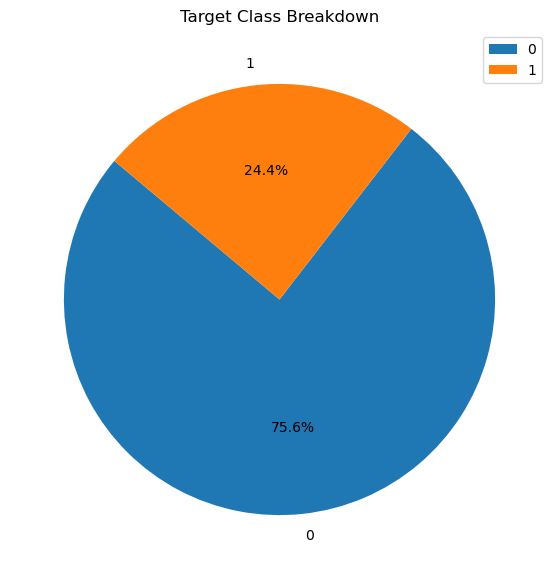

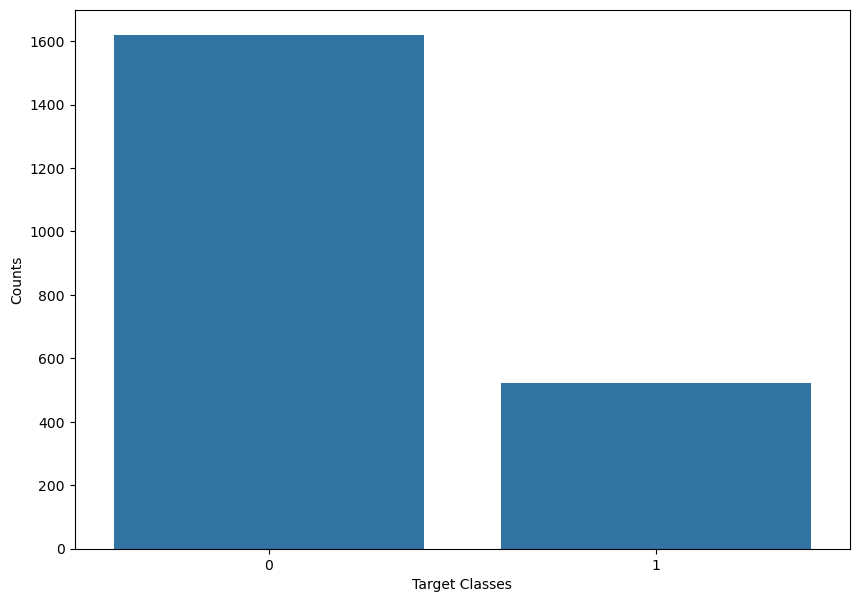

In [8]:
check_class_imbalance(df['infected'])

# Severe Class Imbalance exists

In [9]:
df.dtypes

time          int64
trt           int64
age           int64
wtkg        float64
hemo          int64
homo          int64
drugs         int64
karnof        int64
oprior        int64
z30           int64
preanti       int64
race          int64
gender        int64
str2          int64
strat         int64
symptom       int64
treat         int64
offtrt        int64
cd40          int64
cd420         int64
cd80          int64
cd820         int64
infected      int64
dtype: object

In [10]:
df.describe()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,...,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,1.520804,35.248247,75.125311,0.084151,0.661057,0.131370,95.446470,0.021973,0.550257,...,0.585788,1.979897,0.172978,0.751286,0.362786,350.501169,371.307153,986.627396,935.369799,0.243572
std,292.274324,1.127890,8.709026,13.263164,0.277680,0.473461,0.337883,5.900985,0.146629,0.497584,...,0.492701,0.899053,0.378317,0.432369,0.480916,118.573863,144.634909,480.197750,444.976051,0.429338
min,14.000000,0.000000,12.000000,31.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,49.000000,40.000000,124.000000,0.000000
25%,727.000000,1.000000,29.000000,66.679200,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,263.500000,269.000000,654.000000,631.500000,0.000000
50%,997.000000,2.000000,34.000000,74.390400,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,2.000000,0.000000,1.000000,0.000000,340.000000,353.000000,893.000000,865.000000,0.000000
75%,1091.000000,3.000000,40.000000,82.555200,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,3.000000,0.000000,1.000000,1.000000,423.000000,460.000000,1207.000000,1146.500000,0.000000
max,1231.000000,3.000000,70.000000,159.939360,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,1199.000000,1119.000000,5011.000000,6035.000000,1.000000


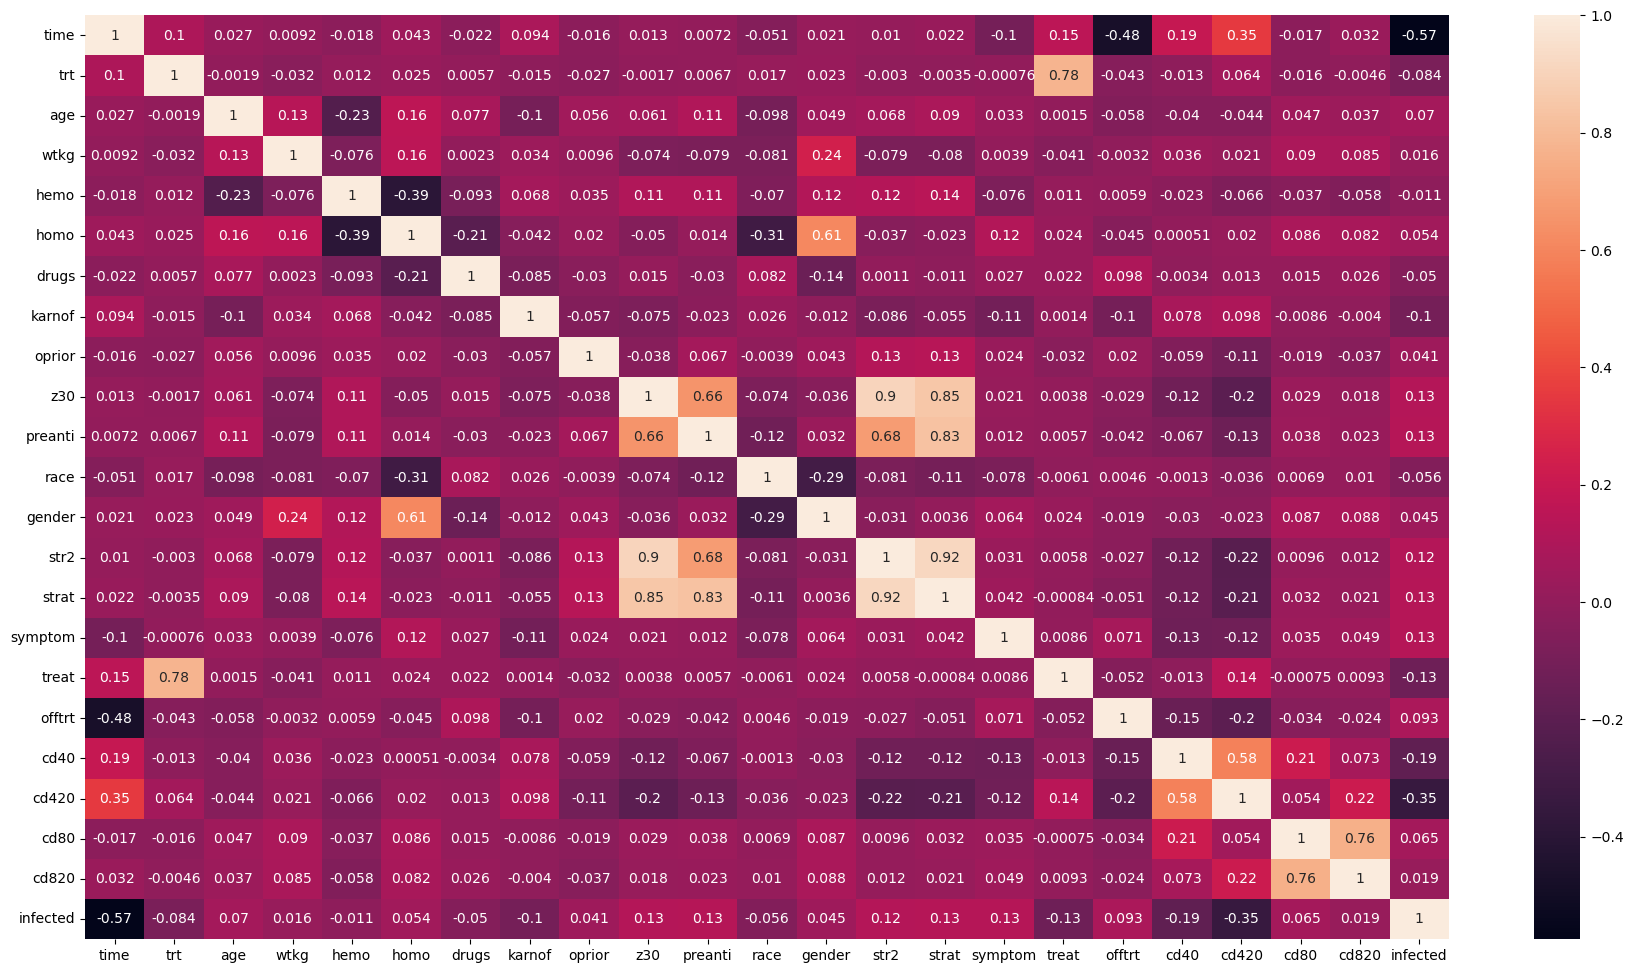

In [14]:
relations = df.corr()
plt.figure(figsize=(22, 12))
sns.heatmap(data=relations, annot=True)
plt.show()

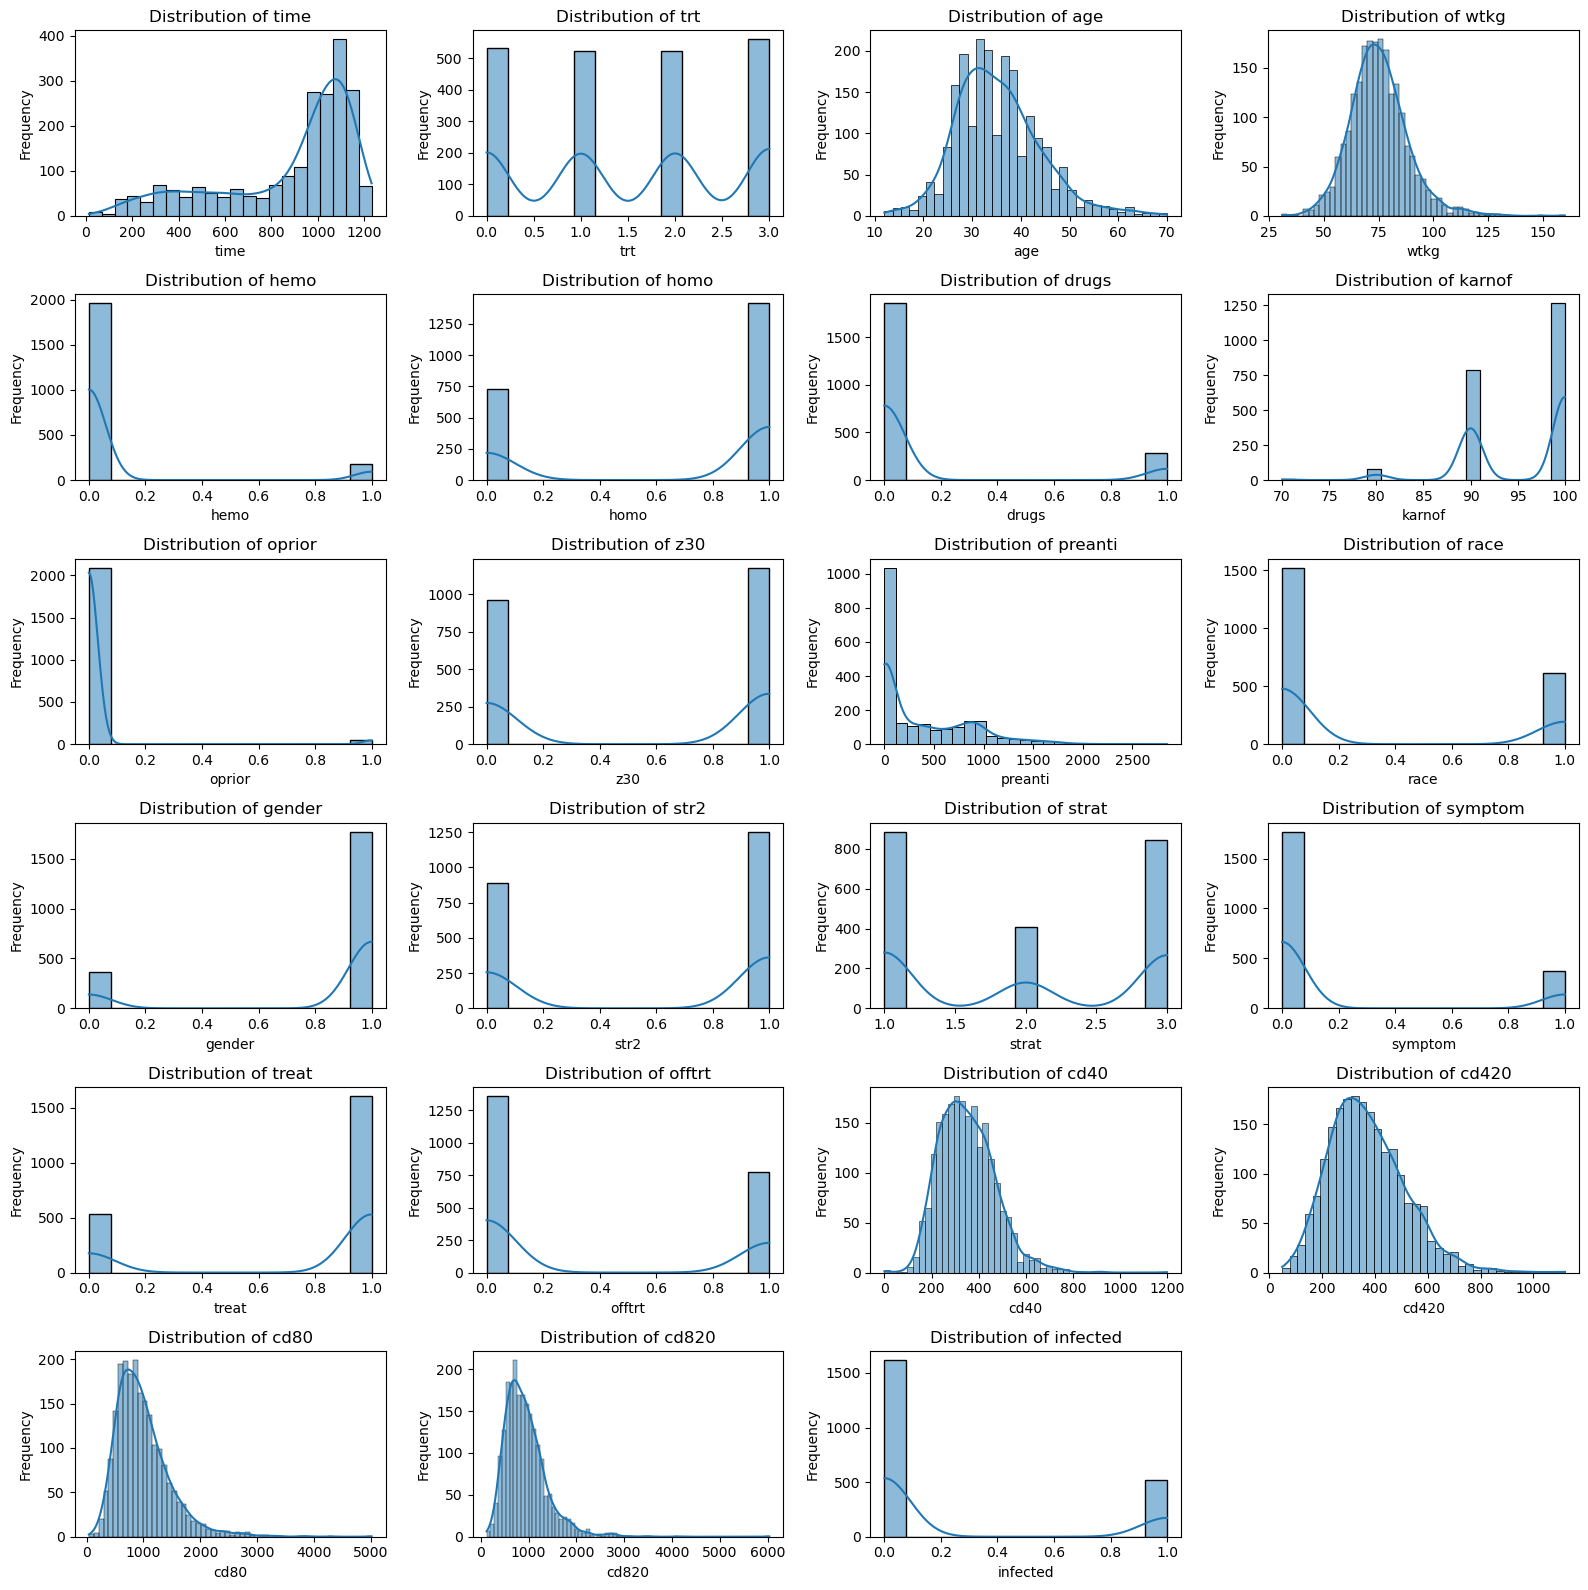

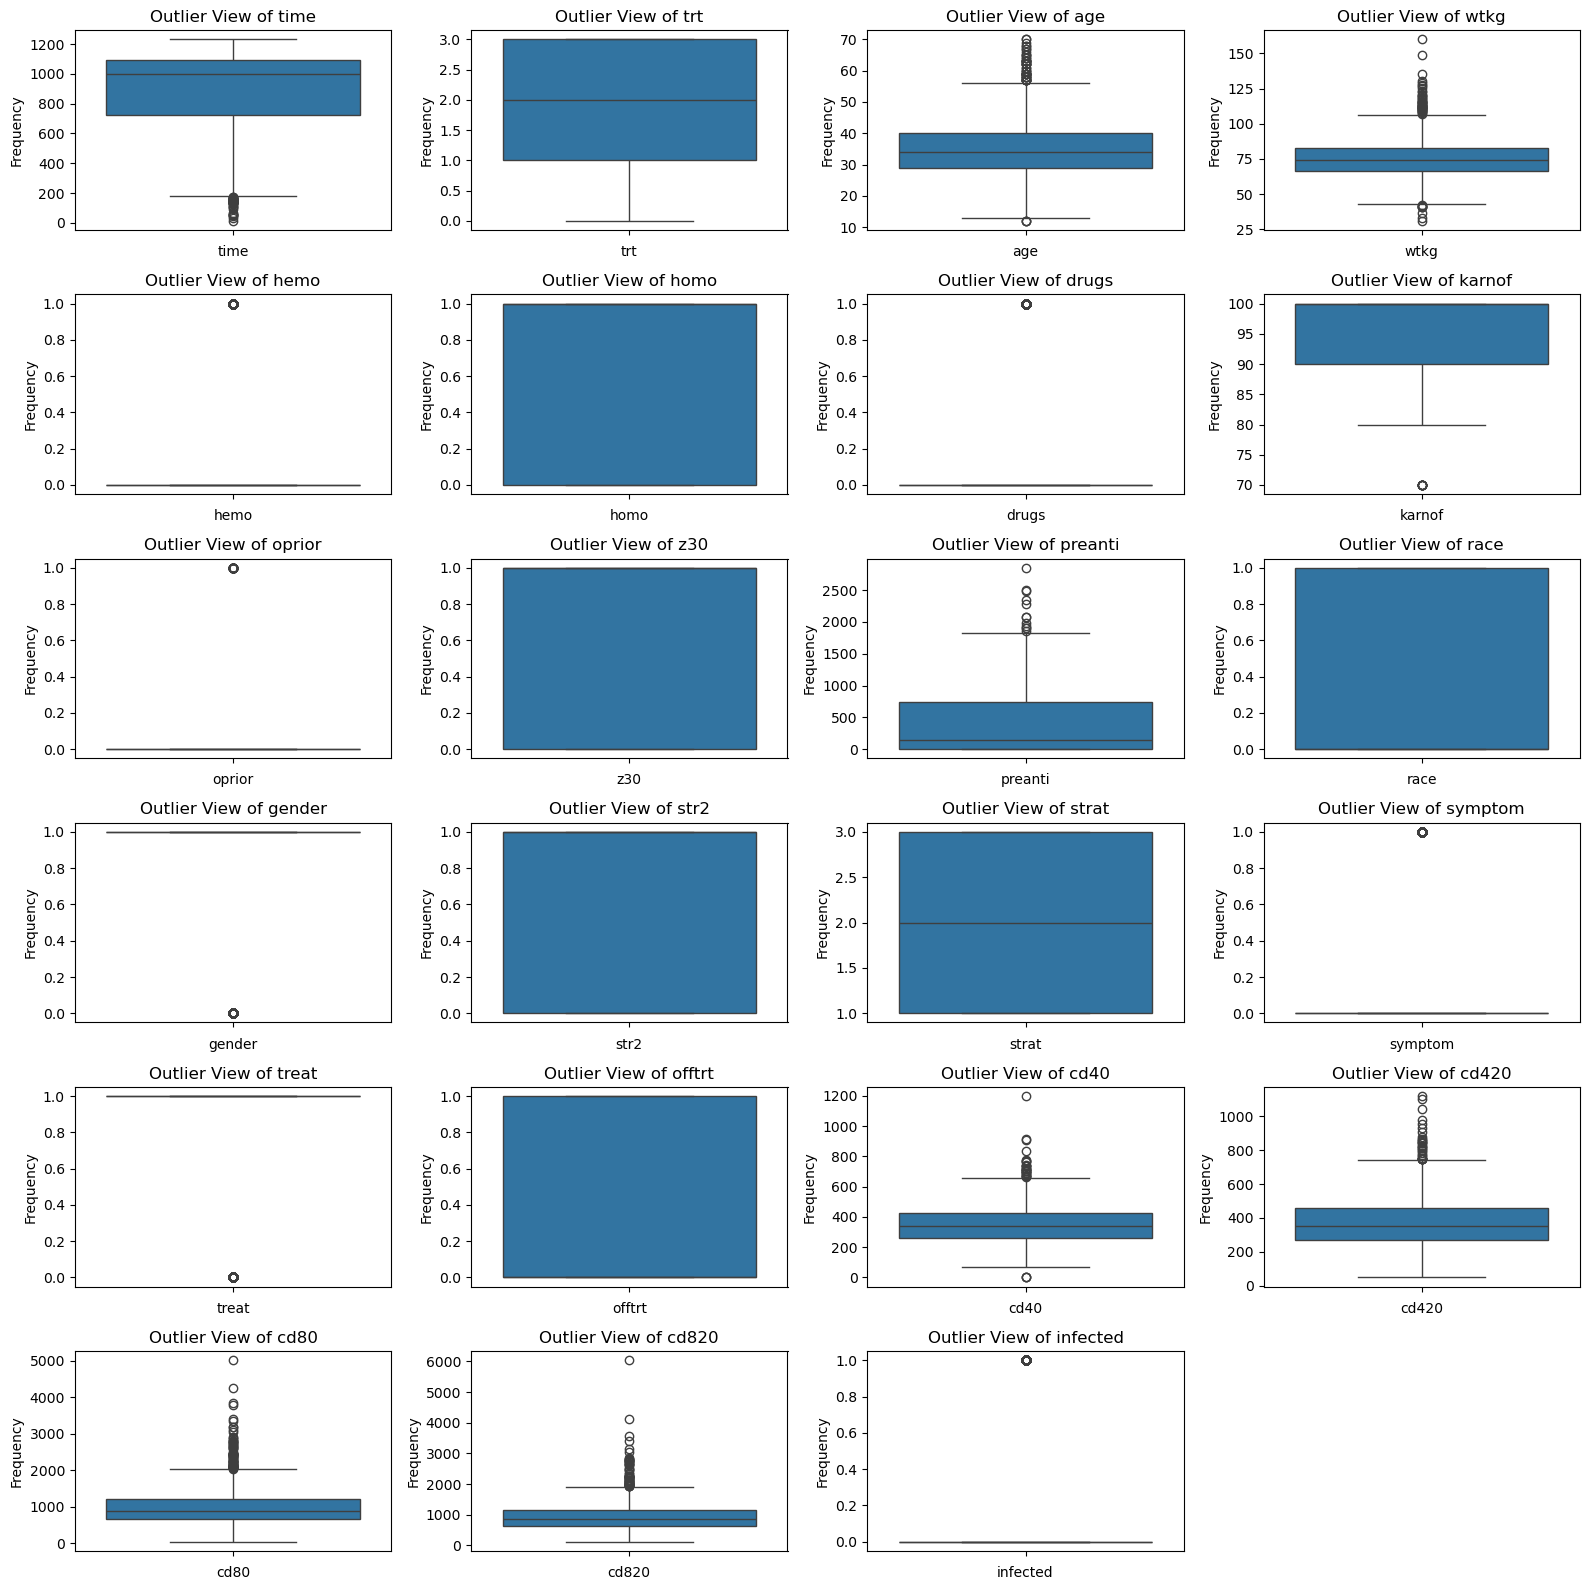

In [31]:
view_dist_shape(df, "hist")
view_dist_shape(df, "box")

# Separate features

In [22]:
X, y = df.drop("infected", axis=1), df["infected"]

# PCA Analysis

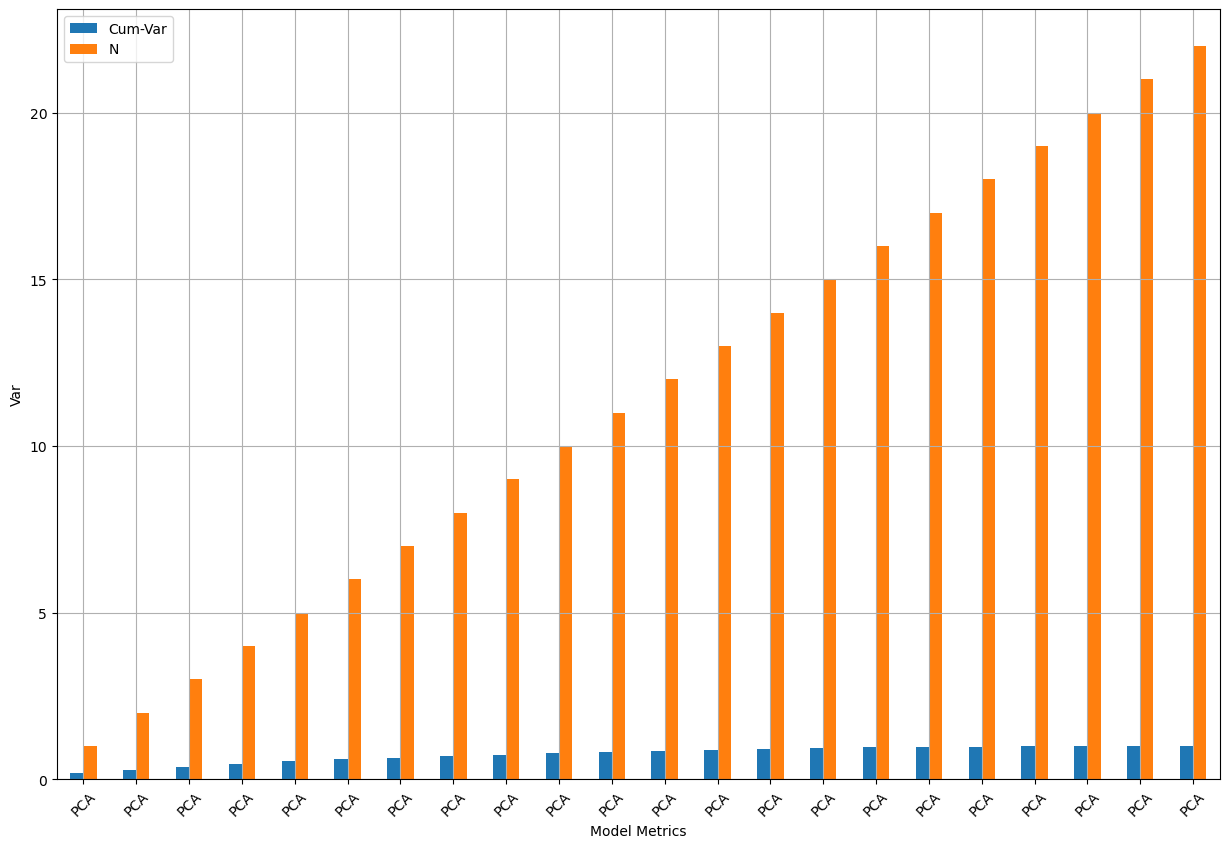

   Model   Cum-Var   N
0    PCA  0.172815   1
1    PCA  0.280957   2
2    PCA  0.376218   3
3    PCA  0.458368   4
4    PCA  0.531113   5
5    PCA  0.594035   6
6    PCA  0.642197   7
7    PCA  0.688701   8
8    PCA  0.734842   9
9    PCA  0.777909  10
10   PCA  0.817141  11
11   PCA  0.853541  12
12   PCA  0.888163  13
13   PCA  0.916584  14
14   PCA  0.940716  15
15   PCA  0.959964  16
16   PCA  0.971061  17
17   PCA  0.980473  18
18   PCA  0.989335  19
19   PCA  0.995260  20
20   PCA  0.999058  21
21   PCA  1.000000  22


In [55]:
pca_analysis(X)

# 9-21 columns holds 70-90% of the variance. We should use this when testing for K best columns once we have developed our model.

# Create metrics

In [66]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True)
precision_metric = make_scorer(precision_score, greater_is_better=True)
recall_metric = make_scorer(recall_score, greater_is_better=True)

# Baseline Model

   Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  precision-Score
0  Dummy  0.244  0.0  0.001     0.244     0.095           1.0            0.244


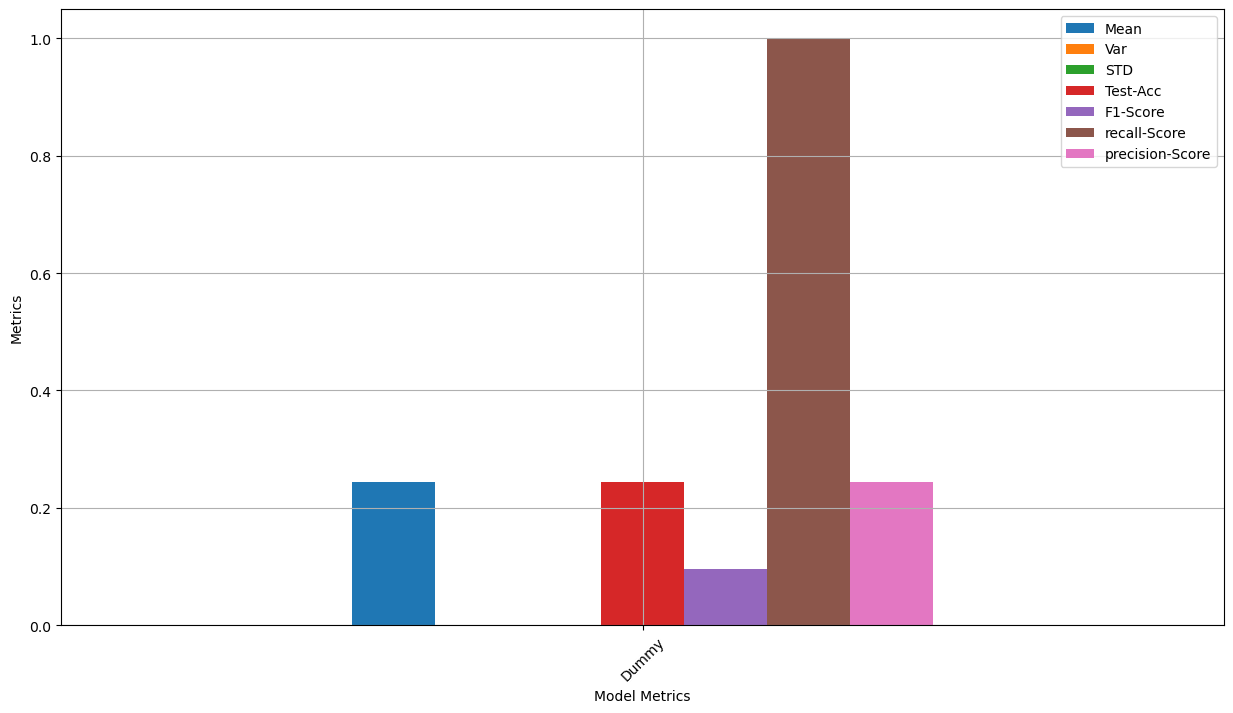

   Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  precision-Score
0  Dummy  0.392  0.0  0.002     0.244     0.095           1.0            0.244


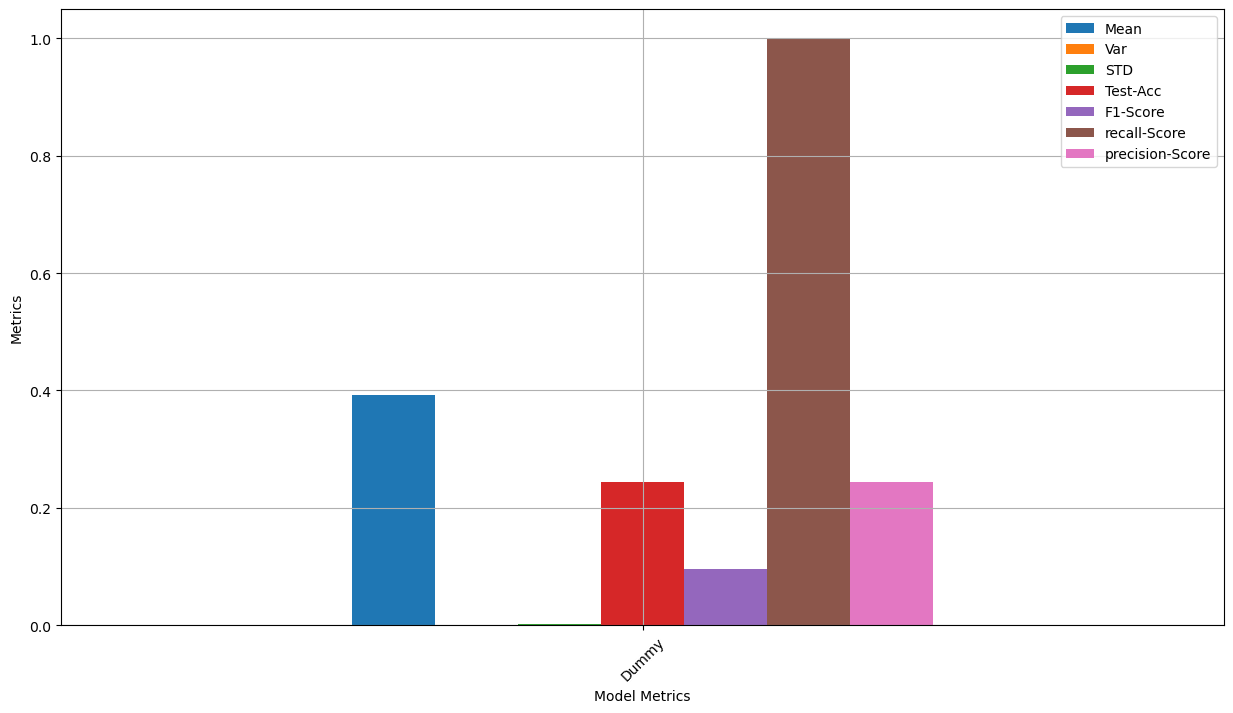

   Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  precision-Score
0  Dummy  0.244  0.0  0.001     0.244     0.095           1.0            0.244


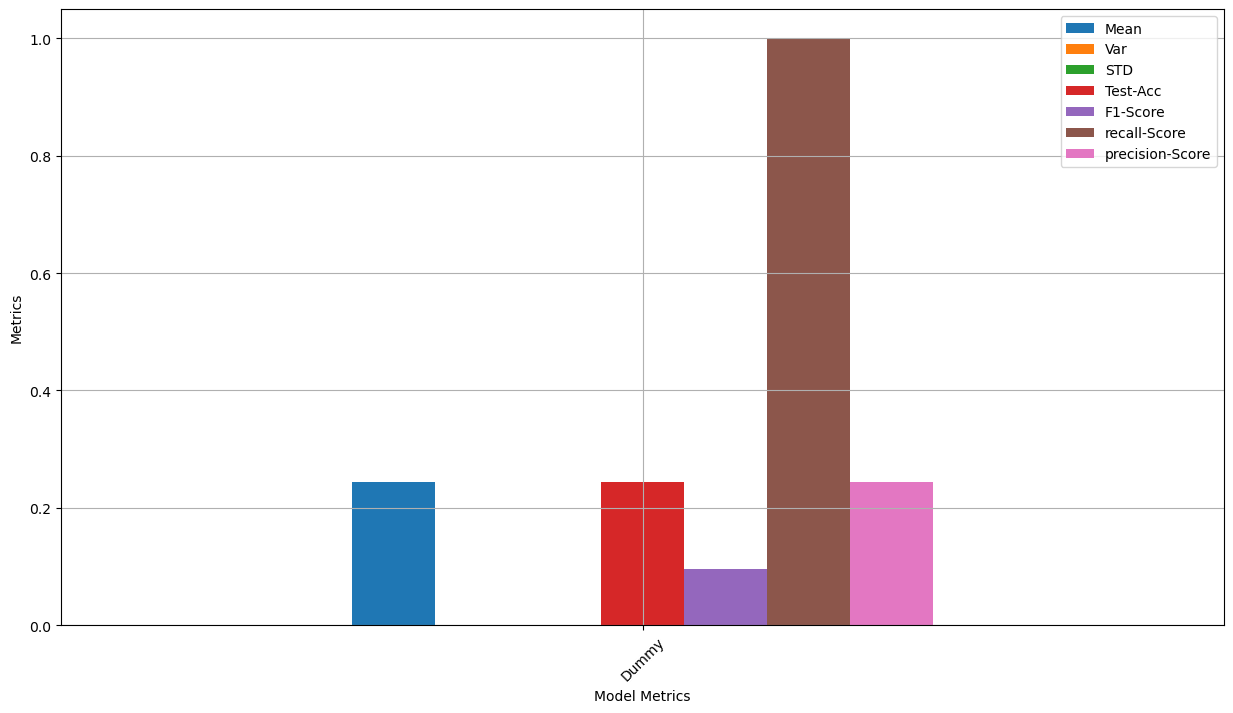

In [76]:
model_names = ["Dummy"]
models = get_selected_models(model_names)


test_selected_models(model_names, models, X, y, acc_metric)
test_selected_models(model_names, models, X, y, f1_metric)
test_selected_models(model_names, models, X, y, precision_metric)

# Advanced Model Metrics

  Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  precision-Score
6   GBC  0.893  0.0  0.018     0.898     0.896         0.739            0.823
4   RFC  0.891  0.0  0.018     0.896     0.894         0.726            0.827
1   SVC  0.889  0.0  0.019     0.886     0.882         0.660            0.839
0    LR  0.888  0.0  0.020     0.889     0.886         0.704            0.814
3   XGB  0.886  0.0  0.018     0.884     0.882         0.729            0.779
5   DTC  0.845  0.0  0.022     0.841     0.842         0.689            0.669
2   KNN  0.828  0.0  0.022     0.827     0.811         0.445            0.741


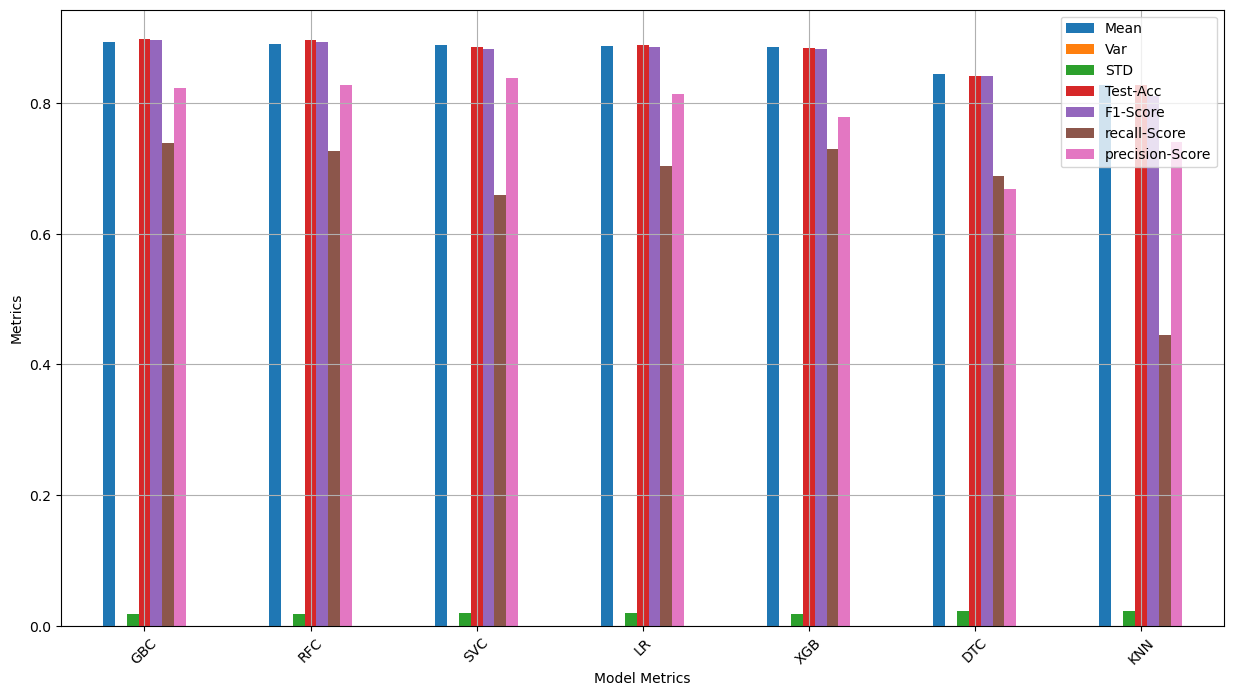

--------------------------------------
ACC
--------------------------------------
  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
6   GBC  0.767  0.002  0.042     0.898     0.896         0.739   
4   RFC  0.763  0.002  0.043     0.892     0.889         0.710   
3   XGB  0.757  0.001  0.038     0.884     0.882         0.729   
0    LR  0.755  0.002  0.044     0.889     0.886         0.704   
1   SVC  0.748  0.002  0.047     0.886     0.882         0.660   
5   DTC  0.685  0.002  0.045     0.843     0.844         0.689   
2   KNN  0.561  0.004  0.066     0.827     0.811         0.445   

   precision-Score  
6            0.823  
4            0.820  
3            0.779  
0            0.814  
1            0.839  
5            0.675  
2            0.741  


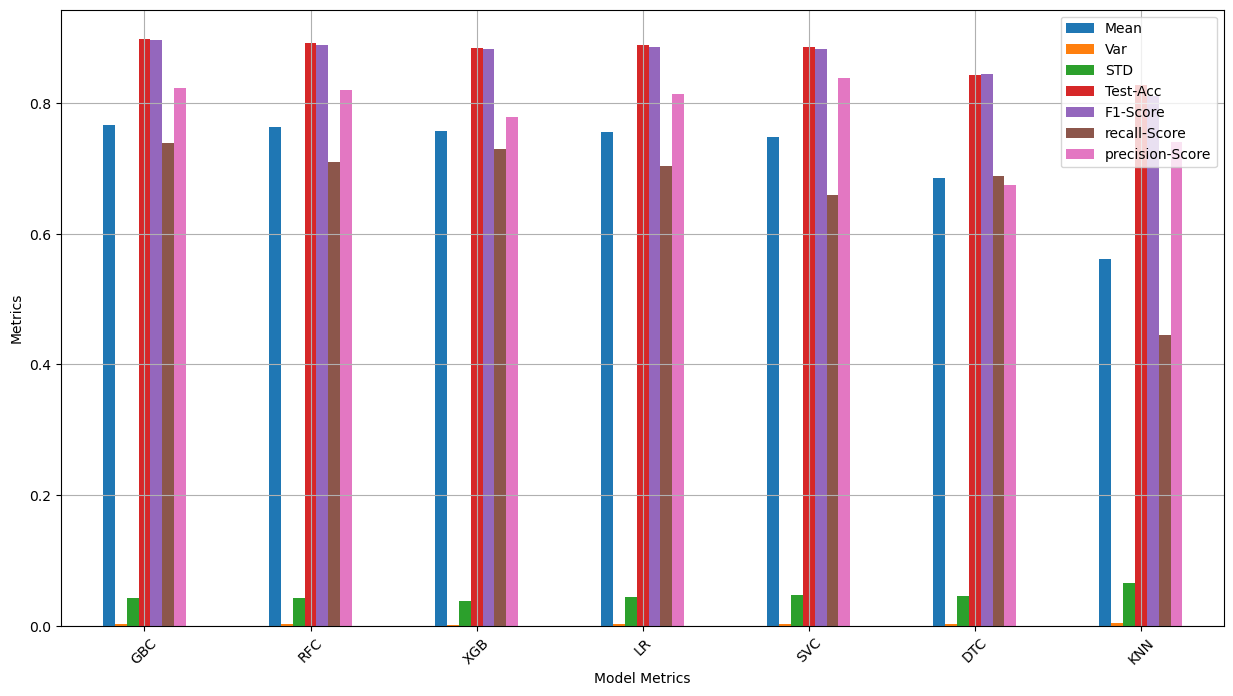

--------------------------------------
F1
--------------------------------------


In [78]:
model_names = ["LR", "SVC", "KNN", "XGB", "RFC", "DTC", "GBC"]
models = get_selected_models(model_names)

test_selected_models(model_names, models, X, y, acc_metric)
print("--------------------------------------")
print("ACC")
print("--------------------------------------")
test_selected_models(model_names, models, X, y, f1_metric)
print("--------------------------------------")
print("F1")
print("--------------------------------------")

# Test Sequential Model

In [61]:
create_MLP_model(X, y)

Epoch 1/100
36/36 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7644 - val_loss: 0.4506 - val_accuracy: 0.7909
Epoch 2/100
36/36 [==============================] - 0s 1ms/step - loss: 0.3459 - accuracy: 0.8499 - val_loss: 0.3384 - val_accuracy: 0.8537
Epoch 3/100
36/36 [==============================] - 0s 983us/step - loss: 0.2863 - accuracy: 0.8709 - val_loss: 0.3244 - val_accuracy: 0.8432
Epoch 4/100
36/36 [==============================] - 0s 947us/step - loss: 0.2498 - accuracy: 0.8953 - val_loss: 0.2933 - val_accuracy: 0.8641
Epoch 5/100
36/36 [==============================] - 0s 944us/step - loss: 0.2327 - accuracy: 0.8997 - val_loss: 0.2919 - val_accuracy: 0.8641
Epoch 6/100
36/36 [==============================] - 0s 933us/step - loss: 0.2103 - accuracy: 0.9110 - val_loss: 0.3115 - val_accuracy: 0.8571
Epoch 7/100
36/36 [==============================] - 0s 911us/step - loss: 0.1941 - accuracy: 0.9206 - val_loss: 0.2958 - val_accuracy: 0.8711
Epo

# Test Sample Models

In [83]:
model_names = ["LR", "SVC", "KNN", "XGB", "RFC", "DTC", "GBC"]
sample_model_names = ["ADASYN", "SMOTE", "BL-SMOTE", "KNN-SMOTE", "SMOTE-T", "SMOTENN", "RANDOM"]
models = get_selected_models(model_names)
sample_models = grab_selected_sampling_models(sample_model_names)